In [142]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [143]:
def generate_mask(hsv_frame):
    light_blue = np.array([14, 90, 95])
    dark_blue = np.array([37, 255, 255])

    light_pink = np.array([50,80,150])
    dark_pink = np.array([179,255,255])

    light_green = np.array([38,23,45])
    dark_green = np.array([52,255,255])

    light_yellow = np.array([94,135,90])
    dark_yellow = np.array([130,255,255])

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    blue_mask = cv2.inRange(hsv_frame, light_blue, dark_blue)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel,iterations=1)
    pink_mask = cv2.inRange(hsv_frame, light_pink, dark_pink)
    pink_mask = cv2.morphologyEx(pink_mask, cv2.MORPH_OPEN, kernel,iterations=1)
    green_mask = cv2.inRange(hsv_frame, light_green, dark_green)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel,iterations=1)
    yellow_mask = cv2.inRange(hsv_frame, light_yellow, dark_yellow)
    yellow_mask = cv2.morphologyEx(yellow_mask, cv2.MORPH_OPEN, kernel,iterations=1)

    image_result = cv2.bitwise_or(blue_mask, pink_mask)
    image_result = cv2.bitwise_or(image_result, green_mask)
    image_result = cv2.bitwise_or(image_result, yellow_mask)

    image_result = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel,iterations=1)
    kernel = np.ones((3, 3), np.uint8)
    image_result = cv2.dilate(image_result, kernel, iterations=1)
    
    
    return image_result, blue_mask, pink_mask, green_mask, yellow_mask
    
def determine_mask_color(image_result, blue_mask, pink_mask, green_mask, yellow_mask):
    # MASK: [UPPER, LOWER]
    PINK = 0
    BLUE = 1
    GREEN = 2
    YELLOW = 3
    
    mask = []
    detected_mask_y = None
    
    blue_mask = cv2.bitwise_and(blue_mask, image_result)
    green_mask = cv2.bitwise_and(green_mask, image_result)
    blue_mask = cv2.bitwise_and(blue_mask, image_result)
    pink_mask = cv2.bitwise_and(pink_mask, image_result)
    
    (blueNumLabels, blueLabels, blueStats, blueCentroids) = cv2.connectedComponentsWithStats(blue_mask, 4, cv2.CV_32S)
    (pinkNumLabels, pinkLabels, pinkStats, pinkCentroids) = cv2.connectedComponentsWithStats(pink_mask, 4, cv2.CV_32S)
    (greenNumLabels, greenLabels, greenStats, greenCentroids) = cv2.connectedComponentsWithStats(green_mask, 4, cv2.CV_32S)
    (yellowNumLabels, yellowLabels, yellowStats, yellowCentroids) = cv2.connectedComponentsWithStats(yellow_mask, 4, cv2.CV_32S)
    
    for i in range(0, blueNumLabels):
        if i != 0 and blueStats[i][4] > 100:
            print(f'blue detected: {blueStats[i][4]}')
            mask.append(BLUE)
            detected_mask_y = blueCentroids[i][1]
    
    for i in range(0, pinkNumLabels):
        if i != 0 and pinkStats[i][4] > 100:
            print('pink detected')
            if detected_mask_y == None:
                mask.append(PINK)
                detected_mask_y = pinkCentroids[i][1]
            elif detected_mask_y < pinkCentroids[i][1]:
                mask.append(PINK)
                return mask
            else:
                return [PINK, BLUE]
            
    for i in range(0, greenNumLabels):
        print(greenStats[i][4])
        print(greenCentroids[i][1])
        if i != 0 and greenStats[i][4] > 100:
            if detected_mask_y == None:
                mask.append(GREEN)
                detected_mask_y = greenCentroids[i][1]
            elif detected_mask_y < greenCentroids[i][1]:
                mask.append(GREEN)
                return mask
            else:
                return [GREEN, mask[0]]
        
    for i in range(0, yellowNumLabels):
        if i != 0 and yellowStats[i][4] > 100:
            if detected_mask_y == None:
                mask.append(YELLOW)
                detected_mask_y = yellowCentroids[i][1]
            elif detected_mask_y < yellowCentroids[i][1]:
                mask.append(YELLOW)
                return mask
            else:
                return [YELLOW, mask[0]]
        
    return mask

In [144]:
frame = cv2.imread('PINK&GREEN.jpg', -1)
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

In [145]:
image_result, blue_mask, pink_mask, green_mask, yellow_mask = generate_mask(hsv_frame)

In [146]:
mask = determine_mask_color(image_result, blue_mask, pink_mask, green_mask, yellow_mask)
print(mask)

pink detected
266580
218.08483757221097
40620
380.04293451501724
[0, 2]


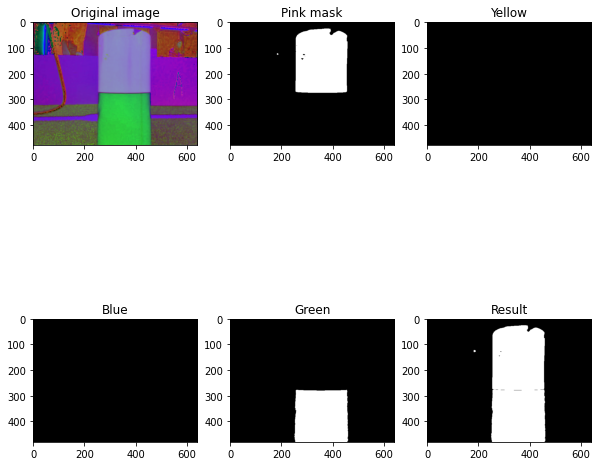

In [147]:
plt.figure(figsize=(10,10))
# Original image
plt.subplot(2,3,1)
plt.title("Original image")
plt.imshow(hsv_frame)

plt.subplot(2,3,2)
plt.title("Pink mask")
plt.imshow(pink_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,3,3)
plt.title("Yellow")
plt.imshow(yellow_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,3,4)
plt.title("Blue")
plt.imshow(blue_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,3,5)
plt.title("Green")
plt.imshow(green_mask,cmap='gray',vmin=0,vmax=255)

plt.subplot(2,3,6)
plt.title("Result")
plt.imshow(image_result,cmap='gray',vmin=0,vmax=255)

In [152]:
output = cv2.connectedComponentsWithStats(image_result, 4, cv2.CV_32S)
(numLabels, labels, stats, centroids) = output
cens = []
objects = []
y_min = 1000
for i in range(0, numLabels):
    if i != 0 and stats[i][4] > 150:
        y_min = min(stats[i][1], y_min)
        cens.append(centroids[i])
        objects.append({"x": stats[i][0], "y": stats[i][1], "width": stats[i][2], "height": stats[i][3], "area": stats[i][4]})
print(cens)
print(objects)

[array([249.,  28.]), array([354.06158804, 259.68268284])]
[{'x': 241, 'y': 20, 'width': 17, 'height': 17, 'area': 164}, {'x': 249, 'y': 28, 'width': 210, 'height': 452, 'area': 89368}]


In [153]:
y_min

20

In [154]:
image_result = image_result[:][y_min:]

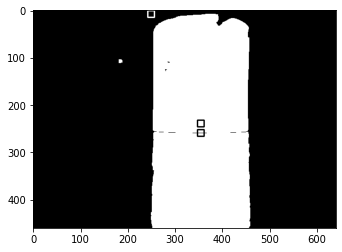

In [155]:
for cen in cens:
    cv2.drawMarker(image_result, (int(cen[0]),int(cen[1])), (0,0,255),cv2.MARKER_SQUARE,15,2)
#cv2.drawMarker(image_result, (int(objects[0]["x"]), int(objects[0]["y"])), (255,0,0),cv2.MARKER_SQUARE,15,2)
plt.imshow(image_result,cmap='gray',vmin=0,vmax=255)

In [150]:
detected_objs = []
LEFT=0
COMPLETE = 1
RIGHT=2
for i, obj in enumerate(objects):
    # In the image, object is too close to the left
    if obj["x"] == 0:
        detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": LEFT})
    else:
        # In the image, object is too close to the right
        if obj["x"] + obj["width"] == hsv_frame.shape[1]:
            detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": RIGHT})
        else:
            detected_objs.append({"centroid": (cens[i][0], cens[i][1]), "width": obj["width"], "height": obj["height"], "status": COMPLETE})

In [151]:
detected_objs

[{'centroid': (354.0613922568124, 259.680512643191),
  'width': 210,
  'height': 452,
  'status': 1}]